In [1]:
import random
seed = random.randint(0, 1000)
random.seed(seed)

### Set hyperparameters for this run

ar = 0.1 # adversarial ratio (\lambda)

n_lat = 4 # size of the AE bottleneck (m)

batch_size = 100 # batch size for training (keep below 360)

lr = 0.001 # learning rate for training

print("Seed: ", seed)
print("Batch Size: ", batch_size)
print("LR: ", lr)
print("AdvRatio: ", ar)

Seed:  568
Batch Size:  100
LR:  0.001
AdvRatio:  0.1


In [2]:
import torch
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import DatasetFolder
import matplotlib.pyplot as plt
from ae_utils_exp import Disentangler, cifar10_norm, cifar10_inorm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import Compose
from train import CIFAR10Pair
from torchvision.models import resnet18, resnet34

np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
from train import get_color_distortion, get_disentangler
from torch.utils.data import DataLoader

ae = get_disentangler()

In [5]:
# set up the dataset retrieval
# loadfunc: given a "x.xxx.npy" file, return a tensor version and its 'name'
train_transform = transforms.Compose([transforms.RandomResizedCrop(32),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          get_color_distortion(s=0.5),
                                          transforms.ToTensor()])
data_dir = "./data"  # get absolute path of data dir
dataset = CIFAR10Pair(root=data_dir,
                        train=True,
                        transform=train_transform,
                        download=True)

Files already downloaded and verified


In [6]:
base_encoder = eval("resnet18")
enc = base_encoder()
print(f"feature dimension of resnet18 encoder: {enc.fc.in_features}")

feature dimension of resnet18 encoder: 512


In [7]:
# Train NashAE on the Beamsynthesis dataset for 100 groups of batches
rec_loss, adv_loss, pred_loss = \
    ae.n_fit(dataset, 10, ar=ar, preds_train_iters=5, lr=lr,\
           batch_size=512, generator_ae=torch.Generator().manual_seed(0),)

Group: 0	10%

/home/scott/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/scott/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Group: 0	100%	Rec: 12.2158	Adv: 0.5770	Pred: 0.2955
Group: 1	100%	Rec: 11.7465	Adv: 2.7342	Pred: 0.0166
Group: 2	100%	Rec: 11.3700	Adv: 3.4108	Pred: 0.0146
Group: 3	100%	Rec: 10.8788	Adv: 3.8062	Pred: 0.0135
Group: 4	100%	Rec: 10.4377	Adv: 4.3195	Pred: 0.0127
Group: 5	100%	Rec: 10.1000	Adv: 4.6431	Pred: 0.0134
Group: 6	100%	Rec: 9.8167	Adv: 4.6292	Pred: 0.0136
Group: 7	100%	Rec: 9.4900	Adv: 4.5655	Pred: 0.0132
Group: 8	100%	Rec: 9.1103	Adv: 4.5425	Pred: 0.0134
Group: 9	100%	Rec: 8.8308	Adv: 4.2959	Pred: 0.0136


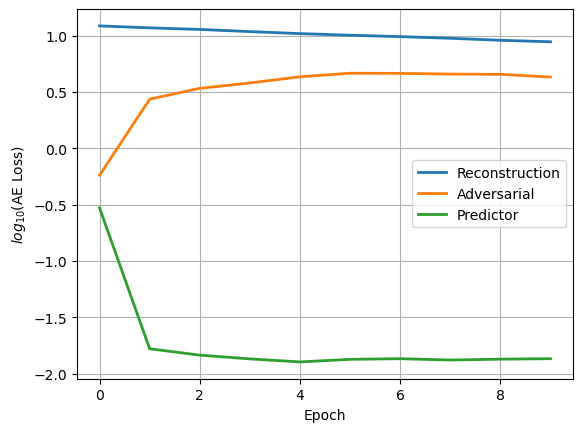

In [8]:
# plot the loss curves on a log scale
plt.figure()
plt.ylabel("$log_{10}$(AE Loss)")
plt.xlabel("Epoch")
plt.plot(np.log10(rec_loss), linewidth=2, label='Reconstruction')
plt.plot(np.log10(adv_loss.abs()), linewidth=2, label='Adversarial')
plt.plot(np.log10(pred_loss), linewidth=2, label='Predictor')
plt.legend()
plt.grid(True, which='both', ls='-')

In [9]:
# Plot traversals of the latent space

z_scores, z_pred_scores, inp, rec = ae.record_latent_space(dataset, batch_size=10, n_batches=10)
z_base = z_scores[1]

fig, ax = plt.subplots(ae.z_dim, 5, figsize=(16,16))
for i in range(ae.z_dim):
    _min = z_scores[:, i].min()
    _max = z_scores[:, i].max()
    variation = torch.linspace(_min, _max, steps=5)
    for j in range(len(variation)):
        z = z_base.clone()
        z[i] = variation[j]
        out = ae.dec(z.to(ae.device)).detach()
        if _max - _min > 0.2:
            ax[i][j].plot(out.squeeze().cpu().numpy(), linewidth=2)
plt.tight_layout()

AttributeError: 'Disentangler' object has no attribute 'record_latent_space'

In [ ]:
from ae_utils_exp import covariance

fig, axes = plt.subplots(1, ae.z_dim, figsize=(16, 4))
for ind in range(ae.z_dim):
    axes[ind].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
    axes[ind].scatter(z_scores[..., ind], z_pred_scores[..., ind])
    axes[ind].set_xlim((-0.05, 1.05))
    axes[ind].set_ylim((-0.05, 1.05))
    cov = covariance(z_scores[..., ind], z_pred_scores[..., ind]).item()
    std = z_scores[..., ind].std(dim=0).item()
    std_p = z_pred_scores[..., ind].std(dim=0).item()
    rho2 = 0.
    if std > 0. and std_p > 0.:
        rho2 = (cov/(std*std_p))**2
    axes[ind].set_title("R2: {:1.3f}".format(rho2))

In [ ]:
# plot original data vs. reconstructions
# push all beamsynthesis data through the model to associate all latent encodings with data generating factors

dataset = DatasetFolder("./beamsynthesis", loadfunc, (".npy",))
dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=1, num_workers=0)

ae.eval()

n_ex = len(dataloader)
latent = np.zeros((n_ex, ae.z_dim))
latent_predict = np.empty((n_ex, ae.z_dim))
param1 = np.zeros((n_ex,))
param2 = np.zeros((n_ex,))
use_param2 = False

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
f_ind = 0

with torch.no_grad():
    for i, (data, lab,) in enumerate(dataloader):
            ex = data[0].to(device).detach_()
            par1 = float(data[1][0])
            param1[i] = par1
            if (len(data) > 2):
                use_param2 = True
                par2 = float(data[2][0])
                param2[i] = par2 # param2 in this case is S1_duty_cycle
            out = ae(ex).squeeze()
            latent[i] = ae.z.cpu().numpy()
            latent_predict[i] = ae.z_pred.cpu().numpy()
            ex = beam_s2s2_norm(ex)
            if (i)%(len(dataloader)//11) == 0 and f_ind < 10:
                ind = f_ind//5, f_ind%5
                if use_param2:
                    axes[ind].set_title("DC:{:1.3f}   FR:{:1.3f}".format(par2, par1))
                else:
                    axes[ind].set_title("Param: {:1.3f}".format(par1))
                axes[ind].plot(ex[0].cpu().numpy(), linewidth=2, label='in')
                axes[ind].plot(out.cpu().numpy(), linewidth=2, label='out')
                axes[ind].legend()
                f_ind += 1

In [ ]:
# define parameters for the 3D depictions of the latent space
view_alt=5
view_ang=90
alpha=0.5

In [ ]:
# count the number of learned latent features
_mins, _min_indices = z_scores.min(dim=0)
_maxes, _max_indices = z_scores.max(dim=0)
diff = _maxes - _mins
print("Number of Learned Features: ", (diff > 0.2).sum().item())

In [ ]:
# plot the learned latent space

fig = plt.figure(figsize=(10, 4))
ax = None
ax = fig.add_subplot(121, projection='3d')

for i in range(ae.z_dim):
    ax.scatter(param2, param1, latent[..., i], label='L{}'.format(i+1), alpha=alpha)

ax.view_init(view_alt, view_ang)
ax.set_xlabel('S2_duty_cycle')
ax.set_ylabel('S2_frequency')
ax.set_zlabel('Latent Activation')
#ax.legend()

ax = fig.add_subplot(122, projection='3d')

for i in range(ae.z_dim):
    ax.scatter(param2, param1, latent[..., i], label='L{}'.format(i+1), alpha=alpha)

ax.view_init(view_alt, view_ang + 45)
ax.set_xlabel('S2_duty_cycle')
ax.set_ylabel('S2_frequency')
ax.set_zlabel('Latent Activation')
ax.legend()

plt.tight_layout()

In [ ]:
# plot the predicted latent space

fig = plt.figure(figsize=(10, 4))
ax = None
ax = fig.add_subplot(projection='3d')

for i in range(ae.z_dim):
    ax.scatter(param2, param1, latent_predict[..., i], label='L{}'.format(i+1), alpha=alpha)

ax.view_init(view_alt, view_ang)
ax.set_xlabel('S2_duty_cycle')
ax.set_ylabel('S2_frequency')
ax.set_zlabel('Latent Prediction')
ax.legend()

plt.tight_layout()

In [ ]:
# initialize the BetaVAE Disentanglement metric linear classifier
from ae_utils_exp import DisentanglementMetric as DM
dm = DM(n_lat, 2, lr=1.0)
freqs = [10., 15., 20.]

In [ ]:
# train the disentanglement metric linear classifier
n_iterations = 10000
bsize = 20
losses = torch.zeros(n_iterations)
for i in range(n_iterations):
    # construct the batch
    batch = torch.zeros((bsize, n_lat))
    # randomly choose data generating factor to hold constant
    is_freq = torch.rand(1) > 0.5
    for b_ind in range(bsize):
        if is_freq: # this is ind 1
            # randomly choose a frequency
            freq_ind = int(torch.rand(1)*3)
            filt = param1 == freqs[freq_ind]
            
        else: # dc is ind 0
            # randomly choose a duty cycle
            tenths = torch.randint(low=2, high=8, size=(1,)).item()
            hundredths = torch.randint(low=0, high=10, size=(1,)).item()
            thousandths = 0 if torch.rand(1) > 0.5 else 5
            dc = tenths * 100 + hundredths * 10. + thousandths
            filt = param2*1000. == dc
        _z_scores = torch.tensor(latent[filt, :])
        _z_scores = _z_scores[torch.randperm(_z_scores.shape[0])]
        # _z_scores is shuffled, select the difference of the first 2 as elem
        ex = (_z_scores[0] - _z_scores[1]).abs()
        batch[b_ind] = ex
    # batch is now constructed
    # train on batch
    loss = dm.fit_batch(1 if is_freq else 0, batch.cpu())
    losses[i] = loss
plt.figure()
plt.plot(losses)

In [ ]:
# evaluate the BetaVAE Disentanglement metric linear classifier
n_iterations = 1000
bsize = 20
n_correct = 0
for i in range(n_iterations):
    # construct the batch
    batch = torch.zeros((bsize, n_lat))
    # randomly choose data generating factor to hold constant
    is_freq = i >= n_iterations//2
    for b_ind in range(bsize):
        if is_freq: # this is ind 1
            # randomly choose a frequency
            freq_ind = int(torch.rand(1)*3)
            filt = param1 == freqs[freq_ind]
        else: # dc is ind 0
            # randomly choose a duty cycle
            tenths = torch.randint(low=2, high=8, size=(1,)).item()
            hundredths = torch.randint(low=0, high=10, size=(1,)).item()
            thousandths = 0 if torch.rand(1) > 0.5 else 5
            dc = tenths * 100 + hundredths * 10. + thousandths
            filt = param2*1000. == dc
        _z_scores = torch.tensor(latent[filt, :])
        _z_scores = _z_scores[torch.randperm(_z_scores.shape[0])]
        # _z_scores is shuffled, select the difference of the first 2 as elem
        ex = (_z_scores[0] - _z_scores[1]).abs()
        batch[b_ind] = ex
    # batch is now constructed
    # train on batch
    prediction = dm(batch.mean(dim=0).unsqueeze(0))
    n_correct += 1. if prediction == is_freq else 0.
print("Acc: {:1.2f}".format(n_correct/n_iterations*100.))